# Code for Models Training is commented as I have saved the models as Pickle file. So ultimately I am using the saved model for evaluation on Test Set. To test the Model Training code. Please uncomment corresponding Markdowns.

# Librairies to be Installed

### !pip3 install seaborn
### !pip3 install catboost
### !pip3 install ipywidgets
### !pip3 install statsmodels
### !jupyter nbextension enable --py widgetsnbextension ### Enabling notebook extension jupyter-js-widgets/extension...

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pickle
import catboost.utils as cbu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from catboost import Pool, CatBoostClassifier, cv
from catboost import CatBoostClassifier, Pool
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report, balanced_accuracy_score

In [3]:
##data has 7 million rows so to avoid local memory issue we can load it by chunks
df_churn = pd.read_csv('train_extended.csv')

## Create the Target or Label from LABEL_max_played_dsi

In [ ]:
## look at the distinct values for last played days
set(df_churn['LABEL_max_played_dsi'].unique())

In [ ]:
## Label the training data based on the value for LABEL_max_played_dsi i.e. 
##  5 ≥ LABEL_max_played_dsi ≤ 18, NOT CHURNED and assign a BOOLEAN value of 0
##  LABEL_max_played_dsi < 5 OR  LABEL_max_played_dsi > 18 , CHURNED and assign a BOOLEAN value of 1

start = time.time()

for n,i in enumerate(df_churn['LABEL_max_played_dsi']):
    if i in list(range(5,19)):
        #df_churn.set_value(n, "Churn", 0) ## not using set_value as it is SET to be Depracated
        df_churn.at[n, "Churn"] = 0
    else:
        #df_churn.set_value(n, "Churn", 1)
        df_churn.at[n, "Churn"] = 1
        
##converting the target variable to integers
df_churn['Churn']= df_churn['Churn'].astype('int64')

print('time taken to update',' ',time.time()-start)

In [ ]:
##check unique values in out target feature
df_churn['Churn'].unique()

In [ ]:
##check wether target variable is good
len([i for i in df_churn['LABEL_max_played_dsi'] if i not in list(range(5,19))]) == len(df_churn[df_churn['Churn'] ==1])

In [ ]:
sns.set(style="darkgrid")
sns.countplot(x='Churn',  data=df_churn)

In [ ]:
## Looking at the Frequency Distribution for the Target Variable i.e Churn
## after examing the plot seems like the distribution is a bit skewed towards the FALSE class
plt.figure(figsize=(12,8))
plt.title('Distribution of Truck Configurations')
plt.xlabel('Number of Axles')
plt.ylabel('Frequency [%]')

ax = ((df_churn.Churn.value_counts()/len(df_churn))*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))
ax.grid(None)

ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(df_churn)/100)
ax2.grid(None)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [ ]:
##verifying if the plot is correct
(len(df_churn[df_churn['Churn']== 1])/len(df_churn))*100 ###28.554036361721796

## Data Engineering - Clean and Transform the data

In [ ]:
pd.set_option("display.max_columns", 100)

In [ ]:
##drop the data kind column as it is not required
df_churn = df_churn.drop(['data_kind'],axis = 1)

In [ ]:
##drop the column with max label size to remove unnecessary infomration
df_churn = df_churn.drop(['LABEL_max_played_dsi'],axis = 1)

In [ ]:
## creating profit column for currencies to reduce dimensionality
df_churn['soft_profit'] = df_churn['soft_positive'].sub(df_churn['soft_negative'], axis = 0).astype('int64') 
df_churn['hard_profit'] = df_churn['hard_positive'].sub(df_churn['hard_negative'], axis = 0).astype('int64')

In [ ]:
##drop the column for soft and hard currency as we have calculated profits
df_churn = df_churn.drop(['soft_positive','soft_negative','hard_positive','hard_negative'],axis = 1)

In [ ]:
## Remove Duplicates if MANY
duplicate = df_churn[df_churn.duplicated()] 
len(duplicate) ###31

In [ ]:
## Deal with Nan Values or NULL values
df_churn.columns[df_churn.isna().any()].tolist() ##'country', 'device_model'

In [ ]:
df_churn['country'].isnull().sum(axis = 0)

In [ ]:
df_churn['device_model'].isnull().sum(axis = 0)

In [ ]:
## as the NULL values for country is very less, replacing NULL values with most frequent country value
df_churn['country'] = df_churn['country'].fillna(value=Counter(df_churn['country']).most_common(1)[0][0])
df_churn['device_model'] = df_churn['device_model'].fillna(value=Counter(df_churn['device_model']).most_common(1)[0][0])

In [ ]:
## Check if any NULL values still exist
df_churn.columns[df_churn.isna().any()].tolist()

In [ ]:
## converting BOOLEAN to INTEGER for Tutorial columns
for i in ['TutorialStart','TutorialStartPart1','TutorialStartPart2','TutorialStartPart3','TutorialStartPart4',
                                     'TutorialStartPart5','TutorialStartPart6','TutorialFinish']:
    df_churn[i] = df_churn[i].astype('int64')
    

In [ ]:
## Move the target variable to the last
target_col = df_churn.pop('Churn')
df_churn.insert(len(df_churn.columns), 'Churn', target_col)

In [ ]:
## seems like Android has more variance here as it accounts to alomost 89% of the platforms
df_churn['platform'].value_counts()

In [ ]:
## extract Category data
obj_df = df_churn.select_dtypes(include=['object']).copy()
obj_df.head()

In [ ]:
## One Hot Encoding platform as both platforms should have same weight
## We could also encode Android as 89 and ios as 11 based on frequency but that might lead to incorrect wieght information
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(obj_df[["platform"]])
#pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()

In [ ]:
### Add Encoded columns to Main dataframe
df_plat = pd.concat([pd.DataFrame(oe_results.toarray(), columns=['platform_Android','platform_iOS']).astype('int64'),df_churn],  axis=1)

In [ ]:
## Drop category column as it had already been OneHOtEncoded
df_plat = df_plat.drop('platform',axis = 1)

In [ ]:
df_plat.head()

# Training first baseline model using Catboost, since we still have 9 Categorical variables

In [ ]:
## Create Features and Target
target = df_plat.loc[:,df_plat.columns == 'Churn']
features = df_plat.loc[:, df_plat.columns != 'Churn'] 

In [ ]:
## Shuffle the data to add randomisation
features,target = shuffle(features, target, random_state=20)

In [ ]:
## list the indices of all the categorical columns
cat_columns = list(set(df_plat.columns) - set(df_plat._get_numeric_data().columns))
categorical_features_indices = []
for n,i in enumerate(list(features.columns)):
    if i in cat_columns:
        categorical_features_indices.append(n)
categorical_features_indices

In [ ]:
## Split data into Train and Validation, with stratify on target to maintain ratio of Target Classes
X_train, X_val, y_train, y_val = train_test_split(features,
                                                    target,
                                                    stratify = target,
                                                    test_size=0.30, random_state = 20)

In [ ]:
y_val.value_counts()

In [ ]:
1188718/475082

In [ ]:
y_train.value_counts()

In [ ]:
2773673/1108524

In [ ]:
## calculating the scale_pos_weight; The weight for class 1 in binary classification. 
## The value is used as a multiplier for the weights of objects from class 1.
counts_elements = np.unique(y_train, return_counts=True)
scale_weight = counts_elements[1][0]/counts_elements[1][1]
scale_weight

In [ ]:
### Initialize Catboost Classifier with correct parameters

train_dataset = Pool(data=X_train,
                        label=y_train,
                        cat_features=categorical_features_indices)

eval_dataset = Pool(data=X_val,
                    label=y_val,
                    cat_features=categorical_features_indices)

model = CatBoostClassifier(iterations= 6000,
                           eval_metric='AUC',
                           #custom_metric = ['AUC','F1', 'Precision', 'Recall'],
                           ## Logloss for imbalanced dataset
                           ## CrossEntropy for probabilities in target
                           depth = 7,
                           learning_rate = 0.2,
                           loss_function = 'Logloss',
                           boosting_type = 'Plain',
                           #class_weights = class_weights,
                           scale_pos_weight = scale_weight,
                           #model_size_reg = 0, -- this is not implemented for GPU usage in Catboost
                           od_type = 'Iter',
                           early_stopping_rounds = 300,## rounds to wait if the accuracy does not increases
                           random_seed = 1234
                           
                          )



In [ ]:
## Train the Model
model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,
          verbose=False, ## to stop printing info of every Iteration
          plot = True
         )

In [ ]:
## Best Iteration
model.get_best_iteration()

In [ ]:
## Best score for AUC and Logloss at best iteration
model.get_best_score()

In [ ]:
## saving model as pickle file for later use, so that we don't have to re-train the model
with open('catboost_baseline.pickle', 'wb') as handle:
    b = pickle.dump(model,handle)

In [ ]:
with open('catboost_baseline.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [ ]:
## defining an ROC curve
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    pl.figure(figsize = (10,7))
    dataset = Pool(data=X,
                    label=y,
                    cat_features=np.where(X.dtypes != np.int64)[0])
    #fpr, tpr, __ = cbu.get_roc_curve(model, dataset, plot = True )
    fpr, tpr, thresholds = cbu.get_roc_curve(model, dataset, plot=True)
    roc_curve_values= cbu.get_roc_curve(model, dataset, plot=False)
    auc = sklearn.metrics.auc(fpr, tpr)
    print('AUC',' ',auc)
    return auc,roc_curve_values

In [ ]:
## Plotting an ROC Curve for validation data
auc,roc_curve_values = calculate_score_on_dataset_and_show_graph(X_val, y_val, model)

In [ ]:
## Using type as FeatureImportance: 
## Equal to PredictionValuesChange for non-ranking metrics and LossFunctionChange for ranking metrics.
feature_importances = model.get_feature_importance(data=train_dataset,
                       type='FeatureImportance',
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

In [ ]:
## from the below graph we can see almost 30 columns account to 70 percent of the total Importance
plt.rcParams["figure.figsize"] = (20,10)
ax = feature_importances.plot('Feature Id', 'Importances', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels, converting Importancs to integer just to visualize properly round to 2 decimal
labels = feature_importances['Importances'].astype('int')

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
## Extracting Features with Importance less than 1 percent
low_imp_features = []
for index, row in feature_importances.iterrows():
    if row['Importances'] < 1:
        low_imp_features.append(row['Feature Id'])

print('Number of features with less than 1 percent Importance',' ',len(low_imp_features))
low_imp_features

In [ ]:
# Re-train Baseline Model without Low Importance Features

In [ ]:
## Remove low Importance features from dataset derived from Model 1
df_imp_features = df_plat[list(set(df_plat.columns) - set(low_imp_features))].copy()

In [ ]:
## Move the target variable to the last
label = df_imp_features.pop('Churn')
df_imp_features.insert(len(df_imp_features.columns), 'Churn', label)

In [ ]:
df_imp_features.info()

In [ ]:
## create target and features
target = df_imp_features.loc[:,df_imp_features.columns == 'Churn']
features = df_imp_features.loc[:, df_imp_features.columns != 'Churn'] 

In [ ]:
# shuffle data to randomize
features,target = shuffle(features, target, random_state=20)

In [ ]:
## list the indices of all the categorical columns
cat_columns = list(set(df_imp_features.columns) - set(df_imp_features._get_numeric_data().columns))
categorical_features_indices = []
for n,i in enumerate(list(features.columns)):
    if i in cat_columns:
        categorical_features_indices.append(n)
categorical_features_indices

In [ ]:
len(target)

In [ ]:
len(features)

In [ ]:
## Stratified split for Tran and Val
X_train, X_val, y_train, y_val = train_test_split(features,
                                                    target,
                                                    stratify = target,
                                                    test_size=0.30, random_state = 20)

In [ ]:
y_val.value_counts()

In [ ]:
1188718/475082

In [ ]:
y_train.value_counts()

In [ ]:
2773673/1108524

In [ ]:
## calculating the scale_pos_weight; The weight for class 1 in binary classification. 
## The value is used as a multiplier for the weights of objects from class 1.
counts_elements = np.unique(y_train, return_counts=True)
scale_weight = counts_elements[1][0]/counts_elements[1][1]
scale_weight

In [ ]:
## Instantiate the Catboost Classifier
train_dataset = Pool(data=X_train,
                        label=y_train,
                        cat_features=categorical_features_indices)

eval_dataset = Pool(data=X_val,
                    label=y_val,
                    cat_features=categorical_features_indices)

model = CatBoostClassifier(iterations= 3000,
                           eval_metric='AUC',
                           #custom_metric = ['AUC','F1', 'Precision', 'Recall'],
                           ## Logloss for imbalanced dataset
                           ## CrossEntropy for probabilities in target
                           depth = 7,
                           learning_rate = 0.2,
                           loss_function = 'Logloss',
                           boosting_type = 'Plain',
                           #class_weights = class_weights,
                           scale_pos_weight = scale_weight,
                           #model_size_reg = 0, -- this is not implemented for GPU usage in Catboost
                           od_type = 'Iter',
                           early_stopping_rounds = 300,## rounds to wait if the accuracy does not increases
                           random_seed = 1234
                           
                          )



In [ ]:
## train the model
model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,
          verbose=False, ## to stop printing info of every Iteration
          plot = True
         )

In [ ]:
model.get_best_iteration()

In [ ]:
model.get_best_score()

In [ ]:
## save the model for later use
with open('model_base_imp_feat.pickle', 'wb') as handle:
    b = pickle.dump(model,handle)

In [ ]:
## defining an ROC curve
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    pl.figure(figsize = (10,7))
    dataset = Pool(data=X,
                    label=y,
                    cat_features=np.where(X.dtypes != np.int64)[0])
    #fpr, tpr, __ = cbu.get_roc_curve(model, dataset, plot = True )
    fpr, tpr, thresholds = cbu.get_roc_curve(model, dataset, plot=True)
    roc_curve_values= cbu.get_roc_curve(model, dataset, plot=False)
    auc = sklearn.metrics.auc(fpr, tpr)
    print('AUC',' ',auc)
    return auc,roc_curve_values

In [ ]:
## Plotting an ROC Curve for Validation Set
auc,roc_curve_values = calculate_score_on_dataset_and_show_graph(X_val, y_val, model)

In [ ]:
## Using type as FeatureImportance: 
## Equal to PredictionValuesChange for non-ranking metrics and LossFunctionChange for ranking metrics.
feature_importances = model.get_feature_importance(data=train_dataset,
                       type='FeatureImportance',
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

In [ ]:
## from the below graph we can see almost 30 columns account to 70 percent of the total Importance
plt.rcParams["figure.figsize"] = (20,10)
ax = feature_importances.plot('Feature Id', 'Importances', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels, converting Importancs to integer just to visualize properly round to 2 decimal
labels = feature_importances['Importances'].astype('int')

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
## Extracting low importance features with Importance less than 1 percent
low_imp_features = []
for index, row in feature_importances.iterrows():
    if row['Importances'] < 1:
        low_imp_features.append(row['Feature Id'])

print('Number of features with less than 1 percent Importance',' ',len(low_imp_features))
low_imp_features

# Feature Selection: After training the baseline model, I will now do the feature selection and see if I can beat the baseline model

In [ ]:
df_plat.head()

In [ ]:
##Calculate the no of Features which has standard deviation as zero. These are the features which are constant. 
num_df = df_plat.iloc[:,:-1].select_dtypes(exclude=['object']).copy()
constant_features = [i for i in num_df.columns if num_df[i].std() == 0]
constant_features

In [ ]:
### Plotting heatmap for pearson co-eff of correlation between features
### Note even on passing all the features excluding Label(Churn) it only calculates the correlation for numerical features
fig, ax =plt.subplots(figsize=(15, 10))
plt.title("Multicollinearity HeatMap")
plt.xticks(rotation=90)
corr_data = df_plat.iloc[:,:-1].corr(method='pearson')
sns.heatmap(corr_data, mask=np.zeros_like(corr_data), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
# Creating correlation matrix
cor_matrix = df_plat.iloc[:,:-1].corr().abs()

In [ ]:
# Selecting upper triangle of correlation matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                  k=1).astype(np.bool))

# Finding index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(); print(to_drop)

# Droping Hihgly Correlated Features
features_sel = df_plat.drop(to_drop, axis=1).copy()

In [ ]:
features_sel.info()

# Training Model with Features Selection and will use validate model with cross folds this time

In [ ]:
features_sel.info()

In [ ]:
## create Features and Target
target = features_sel.loc[:,features_sel.columns == 'Churn']
features = features_sel.loc[:, features_sel.columns != 'Churn'] 

In [ ]:
## randomize the selection
features,target = shuffle(features, target, random_state=1234)

In [ ]:
## list the indices of all the categorical columns
cat_columns = list(set(features_sel.columns) - set(features_sel._get_numeric_data().columns))
categorical_features_indices = []
for n,i in enumerate(list(features.columns)):
    if i in cat_columns:
        categorical_features_indices.append(n)
categorical_features_indices

In [ ]:
len(target)

In [ ]:
len(features)

In [ ]:
## calculating the scale_pos_weight; The weight for class 1 in binary classification. 
## The value is used as a multiplier for the weights of objects from class 1.
counts_elements = np.unique(target, return_counts=True)
scale_weight = counts_elements[1][0]/counts_elements[1][1]
scale_weight

In [ ]:
## Stratified SPlit
X_train, X_val, y_train, y_val = train_test_split(features,
                                                    target,
                                                    stratify = target,
                                                    test_size=0.30, random_state = 42)

In [ ]:
## Instantiate Classifier
train_dataset = Pool(data=X_train,
                        label=y_train,
                        cat_features=categorical_features_indices)

eval_dataset = Pool(data=X_val,
                    label=y_val,
                    cat_features=categorical_features_indices)

model = CatBoostClassifier(iterations= 6000,
                           eval_metric='AUC',
                           #custom_metric = ['AUC','F1', 'Precision', 'Recall'],
                           ## Logloss for imbalanced dataset
                           ## CrossEntropy for probabilities in target
                           depth = 7,
                           learning_rate = 0.08,
                           loss_function = 'Logloss',
                           boosting_type = 'Plain',
                           #class_weights = class_weights,
                           scale_pos_weight = scale_weight,
                           #model_size_reg = 0, -- this is not implemented for GPU usage in Catboost,
                           early_stopping_rounds = 500,## rounds to wait if the accuracy does not increases
                           random_seed = 1234
                           
                          )



In [ ]:
## Train the Model
model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,
          verbose=False, ## to stop printing info of every Iteration
          plot = True
         )

In [ ]:
model.get_best_iteration()

In [ ]:
model.get_best_score()

In [ ]:
## Save model for later evaluation on test data
with open('model_sel_feat.pickle', 'wb') as handle:
    b = pickle.dump(model,handle)

In [ ]:
## defining an ROC curve
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    pl.figure(figsize = (10,7))
    dataset = Pool(data=X,
                    label=y,
                    cat_features=np.where(X.dtypes != np.int64)[0])
    #fpr, tpr, __ = cbu.get_roc_curve(model, dataset, plot = True )
    fpr, tpr, thresholds = cbu.get_roc_curve(model, dataset, plot=True)
    roc_curve_values= cbu.get_roc_curve(model, dataset, plot=False)
    auc = sklearn.metrics.auc(fpr, tpr)
    print('AUC',' ',auc)
    return auc,roc_curve_values

In [ ]:
## Plotting an ROC Curve for Validation Set
auc,roc_curve_values = calculate_score_on_dataset_and_show_graph(X_val, y_val, model)

In [ ]:
## Using type as FeatureImportance: 
## Equal to PredictionValuesChange for non-ranking metrics and LossFunctionChange for ranking metrics.
feature_importances = model.get_feature_importance(data=train_dataset,
                       type='FeatureImportance',
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

In [ ]:
## from the below graph we can see almost 30 columns account to 70 percent of the total Importance
plt.rcParams["figure.figsize"] = (20,10)
ax = feature_importances.plot('Feature Id', 'Importances', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels, converting Importancs to integer just to visualize properly round to 2 decimal
labels = round(feature_importances['Importances'].astype('float64'),1)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
## Extracting low importance features with Feature Importance less than 0.5 percent
low_imp_features = []
for index, row in feature_importances.iterrows():
    if row['Importances'] <= 0.5:
        low_imp_features.append(row['Feature Id'])

print('Number of features with less than or equal to half a percent Importance',' ',len(low_imp_features))
low_imp_features

# Training Model with Feature Selection and Important features based on previous run

In [ ]:
## removing 17 unimportant features
sel_imp_features = features_sel[list(set(features_sel.columns) - set(low_imp_features))].copy()

In [ ]:
sel_imp_features.info()

In [ ]:
## Move the target variable to the last
label = sel_imp_features.pop('Churn')
sel_imp_features.insert(len(sel_imp_features.columns), 'Churn', label)

In [ ]:
## Create Features and Target
target = sel_imp_features.loc[:,sel_imp_features.columns == 'Churn']
features = sel_imp_features.loc[:, sel_imp_features.columns != 'Churn'] 

In [ ]:
# Randomize the selection
features,target = shuffle(features, target, random_state=1234)

In [ ]:
## list the indices of all the categorical columns
cat_columns = list(set(sel_imp_features.columns) - set(sel_imp_features._get_numeric_data().columns))
categorical_features_indices = []
for n,i in enumerate(list(features.columns)):
    if i in cat_columns:
        categorical_features_indices.append(n)
categorical_features_indices

In [ ]:
len(target)

In [ ]:
len(features)

In [ ]:
## Stratified Split
X_train, X_val, y_train, y_val = train_test_split(features,
                                                    target,
                                                    stratify = target,
                                                    test_size=0.30, random_state = 21)

In [ ]:
y_val.value_counts()

In [ ]:
1188718/475082

In [ ]:
y_train.value_counts()

In [ ]:
2773673/1108524

In [ ]:
## calculating the scale_pos_weight; The weight for class 1 in binary classification. 
## The value is used as a multiplier for the weights of objects from class 1.
counts_elements = np.unique(y_train, return_counts=True)
scale_weight = counts_elements[1][0]/counts_elements[1][1]
scale_weight

In [ ]:
## Instantiate the Classifier
train_dataset = Pool(data=X_train,
                        label=y_train,
                        cat_features=categorical_features_indices)

eval_dataset = Pool(data=X_val,
                    label=y_val,
                    cat_features=categorical_features_indices)

model = CatBoostClassifier(iterations= 10000,
                           eval_metric='AUC',
                           #custom_metric = ['AUC','F1', 'Precision', 'Recall'],
                           ## Logloss for imbalanced dataset
                           ## CrossEntropy for probabilities in target
                           depth = 5,
                           learning_rate = 0.05,
                           loss_function = 'Logloss',
                           boosting_type = 'Plain',
                           #class_weights = class_weights,
                           scale_pos_weight = scale_weight,
                           #model_size_reg = 0, -- this is not implemented for GPU usage in Catboost
                           od_type = 'Iter',
                           early_stopping_rounds = 500,## rounds to wait if the accuracy does not increases
                           random_seed = 1234
                           
                          )



In [ ]:
## Train Model
model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,
          verbose=False, ## to stop printing info of every Iteration
          plot = True
         )

In [ ]:
model.get_best_iteration()

In [ ]:
model.get_best_score()

In [ ]:
## Save model for later use
with open('model_sel_feat_imp_feat.pickle', 'wb') as handle:
    b = pickle.dump(model,handle)

In [ ]:
## defining an ROC curve
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    pl.figure(figsize = (10,7))
    dataset = Pool(data=X,
                    label=y,
                    cat_features=np.where(X.dtypes != np.int64)[0])
    #fpr, tpr, __ = cbu.get_roc_curve(model, dataset, plot = True )
    fpr, tpr, thresholds = cbu.get_roc_curve(model, dataset, plot=True)
    roc_curve_values= cbu.get_roc_curve(model, dataset, plot=False)
    auc = sklearn.metrics.auc(fpr, tpr)
    print('AUC',' ',auc)
    return auc,roc_curve_values

In [ ]:
## Plotting an ROC Curve for Validation Set
auc,roc_curve_values = calculate_score_on_dataset_and_show_graph(X_val, y_val, model)

In [ ]:
## Using type as FeatureImportance: 
## Equal to PredictionValuesChange for non-ranking metrics and LossFunctionChange for ranking metrics.
feature_importances = model.get_feature_importance(data=train_dataset,
                       type='FeatureImportance',
                       prettified=True,
                       thread_count=-1,
                       verbose=False)

In [ ]:
## from the below graph we can see almost 30 columns account to 70 percent of the total Importance
plt.rcParams["figure.figsize"] = (20,10)
ax = feature_importances.plot('Feature Id', 'Importances', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels, converting Importancs to integer just to visualize properly round to 2 decimal
labels = feature_importances['Importances'].astype('int')

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
## Extractig low importance feature with Feature Importance less than 1 percent
low_imp_features = []
for index, row in feature_importances.iterrows():
    if row['Importances'] < 1:
        low_imp_features.append(row['Feature Id'])

print('Number of features with less than 1 percent Importance',' ',len(low_imp_features))
low_imp_features

# Make Prediction on test data, exposing the test data first time

## Looking at above collected results, I will use the model with highest AUC score i.e. Model with Feature Selection, I have already saved the model as model_sel_feat.pickle

### Load and Transform Test data

In [ ]:
pd.set_option("display.max_columns", 100)

In [ ]:
##data has 7 million rows so to avoid local memory issue we can load it by chunks
df_test = pd.read_csv('wildlife_churn_prediction_test_extended_(1).csv')

In [ ]:
df_test.info()

In [ ]:
##drop the data kind column as it is not required
df_test = df_test.drop(['data_kind'],axis = 1)

In [ ]:
## creating profit column for currencies to reduce dimensionality
df_test['soft_profit'] = df_test['soft_positive'].sub(df_test['soft_negative'], axis = 0).astype('int64') 
df_test['hard_profit'] = df_test['hard_positive'].sub(df_test['hard_negative'], axis = 0).astype('int64')

In [ ]:
##drop the column for soft and hard currency as we have calculated profits
df_test = df_test.drop(['soft_positive','soft_negative','hard_positive','hard_negative'],axis = 1)

In [ ]:
df_test.columns[df_test.isna().any()].tolist()

In [ ]:
## as the NULL values for country is very less, replacing NULL values with most frequent country value
df_test['country'] = df_test['country'].fillna(value=Counter(df_test['country']).most_common(1)[0][0])
df_test['device_model'] = df_test['device_model'].fillna(value=Counter(df_test['device_model']).most_common(1)[0][0])

In [ ]:
## converting BOOLEAN to INTEGER for Tutorial columns
for i in ['TutorialStart','TutorialStartPart1','TutorialStartPart2','TutorialStartPart3','TutorialStartPart4',
                                     'TutorialStartPart5','TutorialStartPart6','TutorialFinish']:
    df_test[i] = df_test[i].astype('int64')
    

In [ ]:
## One Hot Encoding platform as both platforms should have same weight
## We might also encode Android as 89 and ios as 11 based on frequency but that might lead to incorrect wieght information
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(df_test[["platform"]])
#pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()

In [ ]:
## Add One hot encoded columns to test dataframe
df_test = pd.concat([pd.DataFrame(oe_results.toarray(), columns=['platform_Android','platform_iOS']).astype('int64'),df_test],  axis=1)

In [ ]:
## remove catgory column as it has been Encoded
df_test = df_test.drop('platform',axis = 1)

In [ ]:
## Convert Label to 0 and 1

start = time.time()

df_test['LABEL_churn'] = df_test['LABEL_churn'].astype('int64')

print('time taken to update',' ',time.time()-start)

In [ ]:
## Plot distribution of class for Target
sns.set(style="darkgrid")
sns.countplot(x='LABEL_churn',  data=df_test)

In [ ]:
## Create Feature and Target
test_feature = df_test.loc[:, df_test.columns != 'LABEL_churn'].copy()
test_target = df_test.loc[:, df_test.columns == 'LABEL_churn'].copy()

In [ ]:
## Limit the test data to Training Columns used while Training the Model
test_feature = test_feature[list(features_sel.columns[:-1])]

In [ ]:
## Loading the desired model
with open('model_sel_feat.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [ ]:
# Get predicted classes
y_pred = model.predict(test_feature)
y_pred

In [ ]:
## defining an ROC curve
def calculate_score_on_dataset_and_show_graph(X, y, model):
    import sklearn.metrics
    import matplotlib.pylab as pl
    pl.style.use('ggplot')
    
    dataset = Pool(data=X,
                    label=y,
                    cat_features=np.where(X.dtypes != np.int64)[0])
    #fpr, tpr, __ = cbu.get_roc_curve(model, dataset, plot = True )
    fpr, tpr, thresholds = cbu.get_roc_curve(model, dataset, plot=True)
    roc_curve_values= cbu.get_roc_curve(model, dataset, plot=False)
    auc = sklearn.metrics.auc(fpr, tpr)
    print('AUC',' ',auc)
    return auc,roc_curve_values

In [ ]:
## Plotting an ROC Curve for Test Data
auc,roc_curve_values = calculate_score_on_dataset_and_show_graph(test_feature, test_target, model)

In [ ]:
## create confusion matrix
from sklearn.metrics import confusion_matrix as cm
cm = cm(test_target, y_pred)
cm

In [ ]:
## Plot the confusion matrix for better understanding of Model performance on Test set
import seaborn as sn
plt.figure(figsize = (10,7))
text = np.asarray([['TrueNegative', 'FalseNegative'],['FalsePositive','TruePositive']])
labels = (np.asarray(["{0}\n{1:}".format(text,cm) for text, cm in zip(text.flatten(), cm.flatten())])).reshape(2,2)
## just to verify if the plot is right fecthing fp,fn,tp and tn from scikit-learn
tn, fp, fn, tp = cm.ravel()
print('tn fp fn tp',' ',tn,' ', fp,' ', fn,' ', tp)
#sn.heatmap(cm, annot=True)
sn.heatmap(cm, annot=labels, fmt = '')

In [ ]:
### CLassification Report for Model performance on Test set
from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test_target, y_pred))


# Final Test Results: ## AUC for Test data is  0.7229


### I used the Model3 to make predictions on Test Data as it gave the highest AUC of 0.7109 on Evaluation Set



# Models trained and Evaluated

## All the trained models have been saved as pickle file

### Model1 (catboost_baseline.pickle) is a baseline model using all features after data cleaning

Took 95 minutes as I did not put correct early stopping rounds
best AUC of 71 with best iteration at 1549

Best Score
{'learn': {'Logloss': 0.5923373534611723},
 'validation': {'Logloss': 0.620210294781124, 'AUC': 0.7102109893663907}}
 
### Model2 (model_base_imp_feat.pickle) is a baseline model using important features derived from model 1

baseline with imp features:
 
Took 19 minutes due to early stopping rounds as 300
best AUC of 71 with best iteration at 1354

Best Score
{'learn': {'Logloss': 0.6082826892878942},
 'validation': {'Logloss': 0.621039080948807, 'AUC': 0.7092822450946674}}
 

### Model3 (model_sel_feat.pickle) is trained after conducting Feature Selection using correlation matrix

Model with selected feature:

AUC of 71 in 1h and 51 minutes

get_best_score()
{'learn': {'Logloss': 0.6040452694866675},
 'validation': {'Logloss': 0.6198270500816642, 'AUC': 0.7109365493715099}}
 
 
### Model4 (model_sel_feat_imp_feat.pickle) is Final Model was trained using Feature Selection and important features derived from Model3

Model with feature selection and Important features:

{'learn': {'Logloss': 0.6143608293363605},
 'validation': {'Logloss': 0.6203220856191253, 'AUC': 0.7101058231976527}}
 


# Feature Importance:

## From below Graph we can see that 

#### install_date is the most important column
#### PiggyBankModifiedPoints_sum_dsi3 is the second most important column 

#### As per Catboost Feature Importances caluclation. This is the case for all the models trained

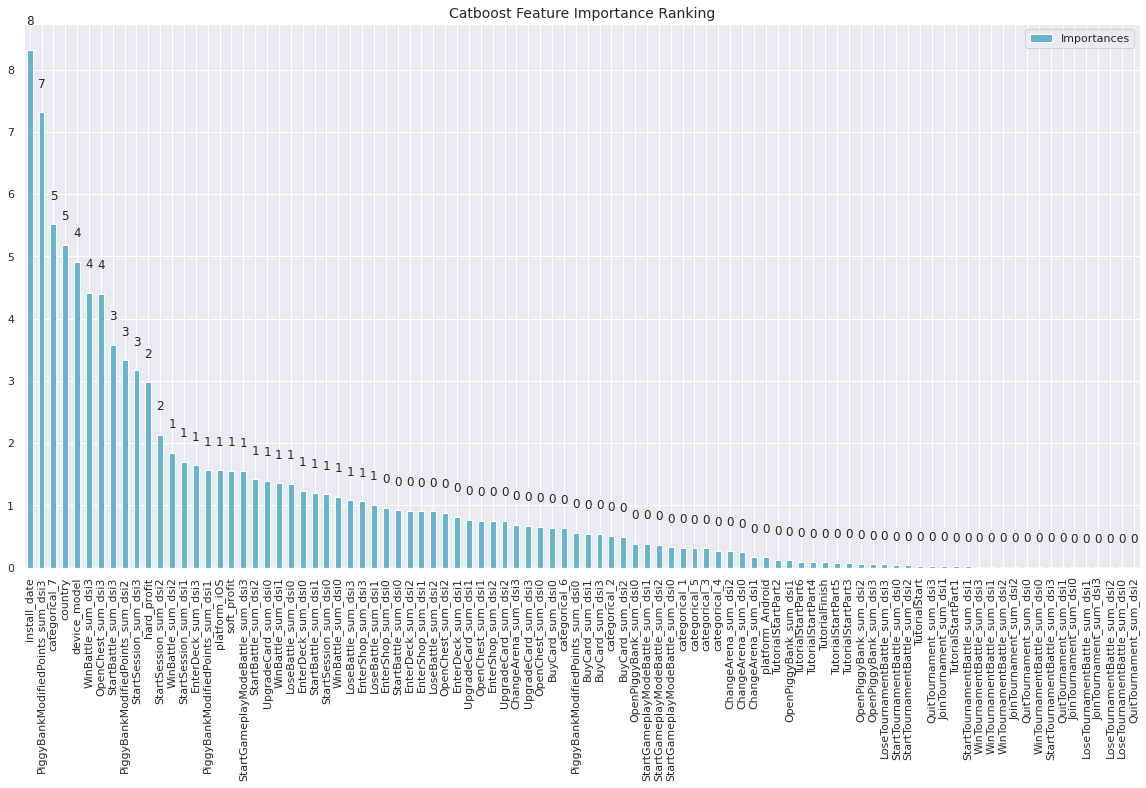

# Challenges

## 1) Huge volume of data caused memory issues on local machine.
## 2) Configuration challenges while trying to setup EC2 instance with jupyter notebook on AWS.
## 3) EC2 machine getting disconnected intermittently due to longer time for Model training beacuse of data volume.
## 4) Large Dimensionality of dataset alongwith Categorical variables with Huge cardinality.
## 5) Data transformation was compute expensive due to large number of rows.
## 6) Could not perform Cross Validation with more than 5 folds because of data volume and time at hand.